# COGS 189: EEG-Based Brain Computer Interfaces
## Assignment 2: P300 Speller Classification via Linear Discriminant Analysis
Created By: Alessandro "Ollie" D'Amico
***
**Please refer to Gradescope/Canvas for assignment deadlines.**
***
## Overview:
For this assignment, we will be working with a BCI competition dataset, with the primary goal of classifying target vs non-target trials from a P300 speller. The data we will be using comes from the 2nd Berlin BCI Competition, and was provided by Wadsworth Center, NYS Department of Health (Jonathan R. Wolpaw). Please go to the following link: 
http://www.bbci.de/competition/ii/
<br><br>
We will be working with **Dataset IIb**. Please click on the description of this dataset (pdf format is superior) and read through the page in order to answer the following questions
Here is a direct link: http://www.bbci.de/competition/ii/albany_desc/albany_desc_ii.pdf
***
***Question 1:*** What is the *dt* for the row/column intensification? 
<br>*(Hint: Remember that from our last assignment, the dt at 1000 Hz = 1ms, 500 Hz = 2ms, 200 Hz = 5ms)*<br>
***Question 2:*** How long (in ms) was each row/column intensified?<br>
***Question 3:*** How much time (in ms) was there between each row/column intensification?<br>
***Question 4:*** What is the sampling rate of the EEG data?<br>
***Question 5:*** How many times was each character intensified?
***
<img src="P300Matrix.gif">

*The .gif above is what the actual task looks like. I created the animation following the description of the dataset. As you can tell, these stimuli are being presented in rapid succession. The participant is instructed to only focus on one character at a time, until they are instructed by the task to look at a new character.*
***
The owners of this data provided us with useful descriptions of the data, along with some matlab code. We will use their documentation to epoch the data so that we can train our classifier. We will be using linear discriminant analysis (LDA) for this problem, as it performs very well on P300 paradigms. Furthermore, this algorithm is rather intuitive. We will be using ```sklearn``` as it will make this assignment easier to follow.

## Section 1: Setup
Before we can begin processing our data, we must first import some useful packages. <br>
- ```numpy``` is used widely for processing numerical data, and supports matrix operations natively. We will be using NumPy arrays to store our data.
- ```scipy``` contains useful functions to calculate filter coefficients and carry out filtering. We will be using SciPy filters to clean our EEG data.
- ```matplotlib``` is used to create plots. We will use it to visually explore our filter and EEG data.
- ```sklearn``` used for machine learning. We will use this to train our classifier and make predictions

In [7]:
import numpy as np                                      # for dealing with data
import matplotlib.pyplot as plt                         # for plotting
from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering
import scipy.signal as signal
from scipy import interp
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import copy
from pathlib import Path # for importing data
import warnings

## Section 2: Pre-processing

### Step 1: Design a filter
The first thing I did, after creating some variables to store our sampling rate, dt, and number of channels, was to create a filter. I used the filter design from the previous assignment, a 0.1 Hz highpass, and a 30 Hz lowpass second-order Butterworth filter. Just like the previous assignment, I used filtfilt to filter the data, For readibility:

We will create some variables to store important values regarding the start and end of our epochs, our sampling rate and our bandpass coefficients. The filter we will be using is a non-causal Butterworth filter. We will use a second-order filter, which due to the nature of using ```filtfilt``` makes it functionally a fourth-order filter since the signal is being filtered twice. Optimal filter design is well beyond the scope of this course, but in general, low order non-causal IIR filters are commonly used for EEG pre-processing. However, IIR filters are easily made unstable so great care must be taken when choosing the order and coefficients. All coefficients chosen in this case have been tested for stability.
<br><br>
Here is the summary of our filter design:
- Filter........: Butterworth (IIR), non-causal ```filtfilt```
- Order.......: 2nd (functionally 4th via ```filtfilt```)
- High pass: 0.1 Hz (low cut of our bandpass)
- Low pass.: 30 Hz (high cut of our bandpass)

In [38]:
# Define our filter variables
fs = 240.0                      # Hz; sampling rate
dt = 1000/fs                    # ms; time between samples
sdt = np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 0.1                        # Hz; our low cut for our bandpass
lp = 30.                        # Hz; our high cut for our bandpass
order = 2                       # filter order (functionally doubled)

# Create our filter coefficient as as a second-order section
# Note: by defining 'fs' we don't divide our windows by the Nyquist
sos = butter(order, [hp, lp], analog = False, btype = 'band', output = 'sos', fs = fs)

### Step 2: Determine our epoch, baseline, and window of focus
For the epoch, we'll plot the activity from 0ms (stimulus onset) to 700 ms (after onset) to ensure we have a waveform similar to the plot provided by the authors. For the baseline, we'll use 0ms to 100 ms after stimulus onset. This baseline window was chosen because every epoch contains information from the previous stimulus due to the small interstimulus interval (ISI). For the window we will select our ERP from, we'll use 250 ms after the stimulus to 450 ms after the stimulus. This choice is consistent with the theoretical expected onset of the P300, and minimizes signals from previous and subsequent stimuli. For readibility:
- Epoch...: 0 - 700 ms
- Baseline: 0 - 100 ms
- ERP.......: 250 - 450 ms

In [44]:
# Define ERP-related variables
epoch_start = 0    # ms
epoch_end = 700    # ms
baseline_start = 0 # ms
baseline_end = 100 # ms
erp_start = 250    # ms
erp_end = 450      # ms

# Let's translate these into index space to save time later
e_s = np.round(epoch_start / sdt).astype(int)     # epoch start
e_e = np.round(epoch_end / sdt).astype(int)       # epoch end
bl_s = np.round(baseline_start / sdt).astype(int) # baseline start
bl_e = np.round(baseline_end / sdt).astype(int)   # baseline end
erp_s = np.round(erp_start / sdt).astype(int)     # ERP start
erp_e = np.round(erp_end / sdt).astype(int)       # ERP end

### Step 3: Epoch our data

We are now ready to extract our signals of interest. All of our data is contained in the *data* subfolder within this directory. Inside are 19 ```.mat``` files. These files were all recorded from the same subject performing unique runs of copy spelling. Copy spelling is when a subject is told what words/letters they will be spelling so that we can label their data and train a classifier to be used during free spelling. In this case, as mentioned in the document, our training data have the prefix ***AAS010*** and ***AAS011*** , while our test (unlabeled) data have the prefix ***AAS012***
<br><br>
Using our previously defined epoch-related and filter-related variables, we will iterate through all of our files, load them in, extract the relevant pieces of information, process our signals, and store them in easily accessed structures. Our training data, ```train_data```, will also be accompanied by ```train_labels``` which will be a binary vector with 0 indicating non-target and 1 indicating a target, and ```train_markers```, which will contain the row/column which was illuminated during the trial. For our testing data, ```test_data``` will contain our epochs of interest, but since we have no labels for this data, it will only be accompanied by ```test_markers```.
<br><br>
It's important to note that we will be filtering our EEG signals as we append them to their respective structures.
<br><br>
***Since the code below is written to be maximally readable, it will be relatively slow.***

In [144]:
# Create empty lists to store our data. We'll conver them into np.arrays at the end
train_data = []
train_labels = []
train_markers = []
test_data = []
test_markers = []

# Load all data in (concatenate train data, keep test separate)
pfx = 'AAS0'
dir_ = './data/'
train = [10, 11]
S = [10, 11, 12]
R = [x for x in range(1, 9)]
for s in S:
    for r in R:
        fp = Path(dir_ + pfx + '%dR0%d.mat' % (s, r))
        if fp.exists() and fp.is_file():
            # If file exists, load, process, append
            print('Processing: ' + str(fp))
            x = loadmat(fp)

            # All we need are the EEG data (signal) and markers (StimulusCode) out of this
            data_   = np.array(x['signal'])        # dim (num(time_points) x num(channels))
            mrks_   = x['StimulusCode'].flatten(); # dim (num(time_points) x 1)

            # Create a stimulus onset array
            onsets = np.zeros_like(mrks_)
            for i in range(mrks_.shape[0]):
                # Roughly equivalent to positive first derivative, but easier to read
                if mrks_[i] != 0 and mrks_[i-1] == 0:
                    onsets[i] = 1
                    
            # Determine all indices where onsets occur
            onsets_ix = np.where(onsets == 1)[0]
        
            # Iterate through onsets, epoch, filter, append
            for i in range(len(onsets_ix)):
                t0 = onsets_ix[i]
                
                # Epoch and correct DC offset of signal pre-filtering
                data = data_[e_s+t0:t0+e_e, :] - np.mean(data_[e_s+t0:t0+e_e, :], 0)
                data = sosfiltfilt(sos, data)
                
                # Now let's baseline correct
                data = data[bl_s+t0:t0+bl_e, :] - np.mean(data_[bl_s+t0:t0+bl_e, :], 0)
                
                # Append data to correct locations
                if s in train:
                    train_data.append(data)
                    train_markers.append(mrks_[t0])
                    train_labels.append(x['StimulusType'].flatten()[t0]) # target or non-target
                else:
                    test_data.append(data)
                    test_markers.append(mrks_[t0])
                    
print('Processing completed!')

# Convert all of our lists into numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
train_markers = np.array(train_markers)
test_data = np.array(test_data)
test_markers = np.array(test_markers)

Processing: data\AAS010R01.mat
Processing: data\AAS010R02.mat
Processing: data\AAS010R03.mat
Processing: data\AAS010R04.mat
Processing: data\AAS010R05.mat
Processing: data\AAS011R01.mat
Processing: data\AAS011R02.mat
Processing: data\AAS011R03.mat
Processing: data\AAS011R04.mat
Processing: data\AAS011R05.mat
Processing: data\AAS011R06.mat
Processing: data\AAS012R01.mat
Processing: data\AAS012R02.mat
Processing: data\AAS012R03.mat
Processing: data\AAS012R04.mat
Processing: data\AAS012R05.mat
Processing: data\AAS012R06.mat
Processing: data\AAS012R07.mat
Processing: data\AAS012R08.mat
Processing completed!


Now that we have our epoched signals, let's divide our ```train_data``` into target and non-target categories for plotting.

**Step 3: Determine how many signals to extract**<br>
There is a lot of mutual information in our data, and it would not be productive to export all of it, specifically because it would take more time to train/cross-validate our model. With this in mind, I decided to ten-fold sub-sample the temporal data, while preseving all 64 channels. I wanted to remain spatially agnostic with these data, although I could have reduced the amount of data by selecting only central + occipital electrodes, for example. With our sub-sampling, we acquire 5 samples per epoch, for all 64 channels, i.e. we obtain a *5 x 64* feature vector for every stimulus. For readibility:
- Sub-sampling..........: 10-fold
- Samples per epoch.: 5
- Number of channels: 64

The following is a visual explanation of the baseline, ERP window selection, and sub-sampling routine (on a single channel, using the figure provided by the author):

<img src="img1.png">

**Step 4: Extract the signals, and markers/labels**<br>
After deciding on everything, I extracted the signals and markers of interest. The exact details of this can be found in the MATLAB syntax. I saved the signals in a *5 x 64 x n_stimuli* numpy array, using a helpful function I found online. I saved the labels and markers of the training data in a *n_stimuli x 2* CSV, and the markers of the test data in an *n_stimuli x 1*  CSV. For readibility:
- Train signals...............: 'train_df.npy' (5 x 64 x n_stimuli)
- Test signals................: 'test_df.npy'  (5 x 64 x n_stimuli)
- Train markers + labels: 'train_la.csv' (n_stimuli x 2)
- Test markers...............: 'test_la.csv'  (n_stimuli x 1)

***

Now that we understand how our data were pre-processed and extracted, let's load it all in!

In [3]:
# For Lab meeting: extract target v non-target
t = [];
n = [];

for i in np.where(onsets == 1)[0]:
    if labels[i][0] == 1:
        t.append(data_[i+e_s:i+e_e])
    else:
        n.append(data_[i+e_s:i+e_e])
        
# Check shapes
print('Num targets: %d' % len(t))
print('Num non-targets: %d' % len(n))

Num targets: 90
Num non-targets: 450


In [37]:
# Let's create a copy of data_ which we can filter continuously
data = copy.deepcopy(data_)

# Generate coefficients
order = 3 # for iir
window = [0.1, 30]
b_iir, a_iir = signal.butter(N=order, Wn=window, btype='bandpass', fs=fs)
taps = 101 # for fir
b_fir = signal.firwin(numtaps=taps, cutoff=window, pass_zero='bandpass', fs=fs)
a_fir = 1

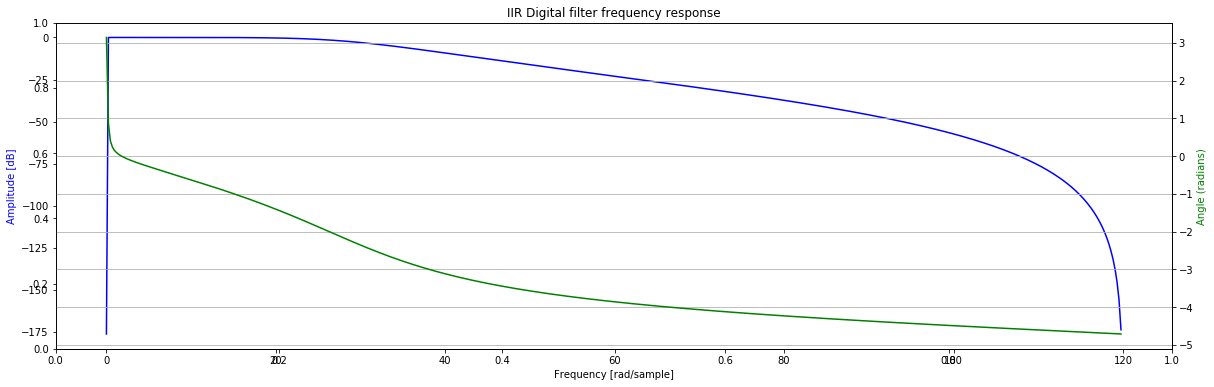

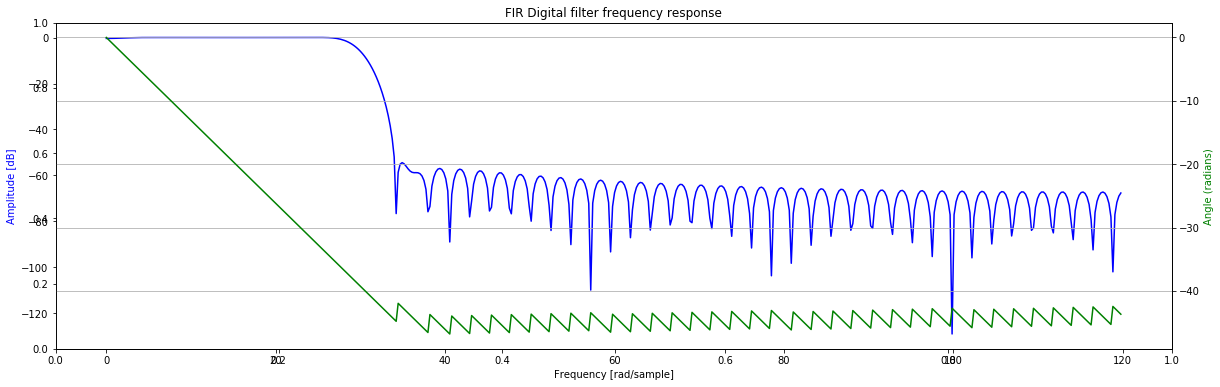

In [38]:
# Examine filter responses of iir vs fir and psd of iir'd vs fir'd
# Code adapted from:
# https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.freqz.html
# Ignore div 0 and plot warnings
warnings.filterwarnings('ignore')
# IIR freqz
w_iir, h_iir = signal.freqz(b_iir, a_iir, whole=False, fs=fs)
#h_iir[0] = 1j**-100 # prevent division by 0 error
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
plt.title('IIR Digital filter frequency response')
ax1 = fig.add_subplot(111)
plt.plot(w_iir, 20 * np.log10(abs(h_iir)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles_iir = np.unwrap(np.angle(h_iir))
plt.plot(w_iir, angles_iir, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
#plt.axis('tight')
plt.show()
# FIR freqz
w_fir, h_fir = signal.freqz(b_fir, a_fir, whole=False, fs=fs)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
plt.title('FIR Digital filter frequency response')
ax1 = fig.add_subplot(111)
plt.plot(w_fir, 20 * np.log10(abs(h_fir)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles_fir = np.unwrap(np.angle(h_fir))
plt.plot(w_fir, angles_fir, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
#plt.axis('tight')
plt.show()

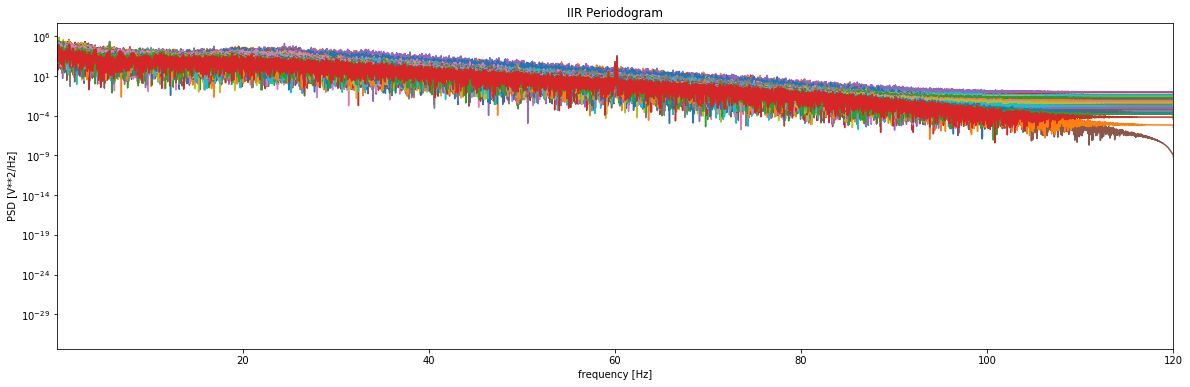

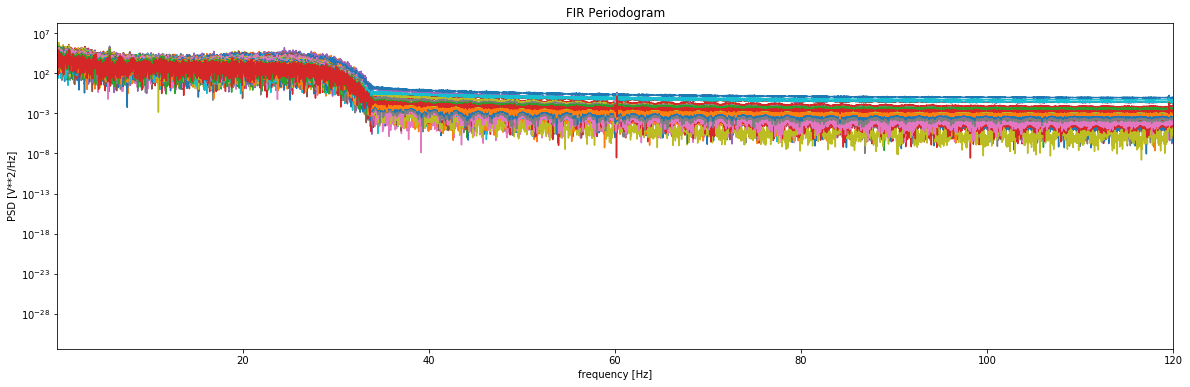

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
data_iir = signal.lfilter(b_iir, a_iir, data, axis=0)
f_iir, P_iir = signal.periodogram(data_iir, fs, axis = 0)
plt.semilogy(f_iir, P_iir)
plt.xlim([0.1, 120])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('IIR Periodogram')
plt.show()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
data_fir = signal.lfilter(b_fir, a_fir, data, axis=0)
f_fir, P_fir = signal.periodogram(data_fir, fs, axis = 0)
plt.semilogy(f_fir, P_fir)
plt.xlim([0.1, 120])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('FIR Periodogram')
plt.show()

In [40]:
# Filter data continuously
#data_f = signal.lfilter(b_iir, a_iir, data)
data_f = signal.filtfilt(b_iir, a_iir, data.T).T

# Epoch continuously filtered data
t_c = [];
n_c = [];

for i in np.where(onsets == 1)[0]:
    if labels[i][0] == 1:
        t_c.append(data_f[i+e_s:i+e_e])
    else:
        n_c.append(data_f[i+e_s:i+e_e])

In [41]:
# Filter epoched data 
t_f = []
for i in range(len(t)):
    #t_f.append(signal.lfilter(b, a, t[i]))
    t_f.append(signal.filtfilt(b_iir, a_iir, t[i].T).T)
    
n_f = []
for i in range(len(n)):
    #n_f.append(signal.lfilter(b, a, n[i]))
    n_f.append(signal.filtfilt(b_iir, a_iir, n[i].T).T)

(array([ 0,  0,  0, ..., 89, 89, 89], dtype=int64),
 array([  0,   0,   0, ..., 124, 124, 124], dtype=int64),
 array([ 0,  1,  2, ..., 61, 62, 63], dtype=int64))

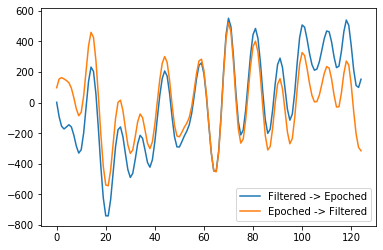

In [42]:
# Plot first epoch
trial = 20
t_f_blc = t_f[trial][:, 0] - np.mean(t_f[trial][:, 0])
t_c_blc = t_c[trial][:, 0] - np.mean(t_c[trial][:, 0])
plt.plot(t_f_blc)
plt.plot(t_c_blc)
plt.legend(['Filtered -> Epoched', 'Epoched -> Filtered'])
np.where(np.equal(t_f, t_c) == False)

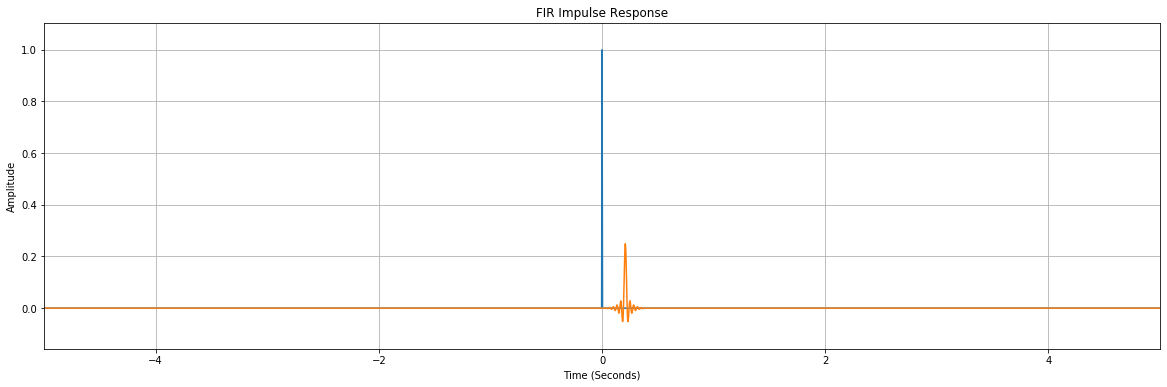

Impulse shifted by 50samples
Impulse shifted by 0.20833333333333334 seconds


In [43]:
# Create a unit impulse function
num_zeros = 10000 # total
times = np.arange(-num_zeros//2, num_zeros//2)*(1/fs)
imp = signal.unit_impulse(num_zeros, 'mid')
# Filter the impulse fir and plot the responses
y_fir = signal.lfilter(b_fir, a_fir, imp)
# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
plt.plot(times, imp)
plt.plot(times, y_fir)
plt.xlim([-5, 5])
plt.margins(0.1, 0.1)
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.title('FIR Impulse Response')
plt.show()
print('Impulse shifted by ' + str(np.argmax(y_fir) - np.argmax(imp)) + 'samples')
print('Impulse shifted by ' + str((np.argmax(y_fir) - np.argmax(imp))*(1/fs)) + ' seconds')

In [45]:
# test FIR filter on continuous data
data_filt = signal.lfilter(b_fir, a_fir, data, axis = 0);
data_filtfilt = signal.filtfilt(b_fir, a_fir, data, axis = 0)

50


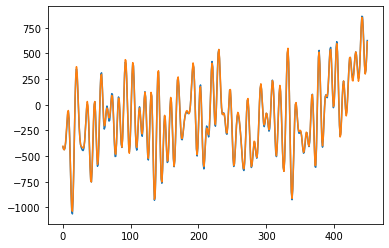

In [50]:
s = 250;
e = 700;
delay = int((taps-1)/2) # assumes ntaps is odd
plt.plot(data_filt[s+delay:e+delay, 0])
plt.plot(data_filtfilt[s:e, 0])
print(delay)

In [69]:
# Epoch FIR filtered data
t_c_fir_ff = [];
n_c_fir_ff = [];
t_c_fir_f  = [];
n_c_fir_f  = [];

for i in np.where(onsets == 1)[0]:
    if labels[i][0] == 1:
        t_c_fir_ff.append(data_filtfilt[i+e_s:i+e_e])
        t_c_fir_f.append(data_filt[i+e_s+delay:i+e_e+delay])
    else:
        n_c_fir_ff.append(data_filtfilt[i+e_s:i+e_e])
        n_c_fir_f.append(data_filt[i+e_s+delay:i+e_e+delay])

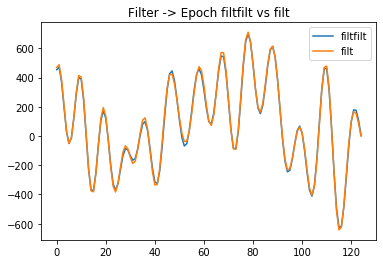

In [74]:
plt.plot(t_c_fir_ff[0][:,0]);
plt.plot(t_c_fir_f[0][:,0]);
plt.title('Filter -> Epoch filtfilt vs filt');
plt.legend(['filtfilt', 'filt']);

In [95]:
# We actually must re-epoch the data since we need at least delay samples after e_e
# For Lab meeting: extract target v non-target
t_ = [];
n_ = [];

for i in np.where(onsets == 1)[0]:
    if labels[i][0] == 1:
        t_.append(data_[i+e_s:i+e_e+delay])
    else:
        n_.append(data_[i+e_s:i+e_e+delay])

# Filter epoched data 
t_f_fir = []
for i in range(len(t)):
    t_f_fir.append(signal.lfilter(b_fir, a_fir, t_[i], axis = 0))
    #t_f.append(signal.filtfilt(b, a, t[i].T).T)
    
n_f_fir = []
for i in range(len(n)):
    n_f_fir.append(signal.lfilter(b_fir, a_fir, n_[i], axis = 0))
    #n_f.append(signal.filtfilt(b, a, n[i].T).T)

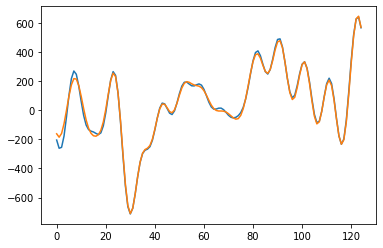

In [96]:
# Plot
plt.plot(t_f_fir[1][delay:, 0])
plt.plot(t_c_fir_ff[1][:, 0])

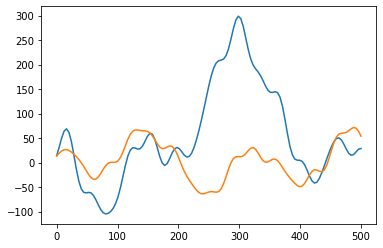

In [97]:
# Plot average ERPs
chan = 10;
times = np.linspace(e_s_, e_e_, (e_e-e_s))
# FIR
t_avg_fir = np.mean(t_f_fir, axis=0)
t_avg_fir = t_avg_fir[delay:, :] # correct for delay
n_avg_fir = np.mean(n_f_fir, axis=0)
n_avg_fir = n_avg_fir[delay:, :] # correct for delay
plt.plot(times, t_avg_fir[:, chan]);
plt.plot(times, n_avg_fir[:, chan]);

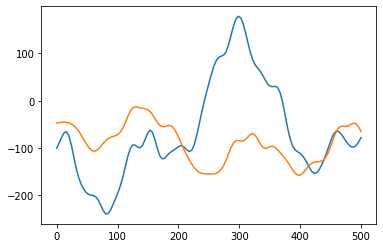

In [93]:
# Plot average ERPs
chan = 10;
# FIR
t_avg_iir = np.mean(t_f, axis=0)
n_avg_iir = np.mean(n_f, axis=0)
plt.plot(times, t_avg_iir[:, chan]);
plt.plot(times, n_avg_iir[:, chan]);

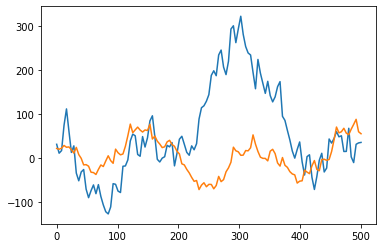

In [94]:
# Epoch and plot raw data
t_unf = [];
n_unf = [];

for i in np.where(onsets == 1)[0]:
    if labels[i][0] == 1:
        t_unf.append(data[i+e_s:i+e_e])
    else:
        n_unf.append(data[i+e_s:i+e_e])
        
t_avg_unf = np.mean(t_unf, axis=0)
n_avg_unf = np.mean(n_unf, axis=0)
plt.plot(times, t_avg_unf[:, chan]);
plt.plot(times, n_avg_unf[:, chan]);

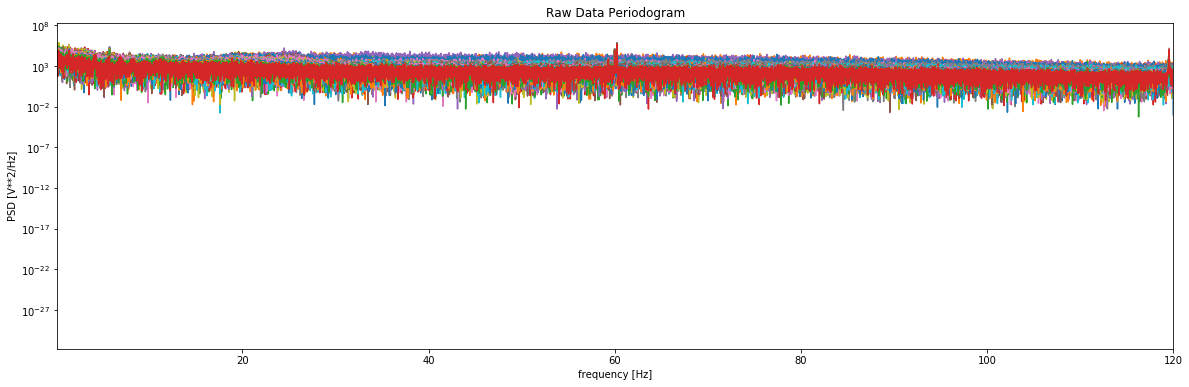

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
f, P = signal.periodogram(data, fs, axis = 0)
plt.semilogy(f, P)
plt.xlim([0.1, 120])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Raw Data Periodogram')
plt.show()

In [19]:
t_avg_fir.shape

(275, 64)

In [ ]:
# Load in train signals and markers + labels
X_train = np.load('train_df.npy')
markers_train = np.genfromtxt('train_la.csv', delimiter=',').astype(int) # also contains labels in first column
y = markers_train[:, 0] # let's only save the labels

# Let's also load in our test signals and markers
X_test = np.load('test_df.npy')
markers_test = np.genfromtxt('test_la.csv', delimiter=',').astype(int)

# Let's print out the shapes of our data
print('X_train shape is: ' + str(X_train.shape))
print('y shape is......: ' + str(y.shape))
print('X_test shape is.: ' + str(X_test.shape))

As we can see, the dimensions of *X_train* are 5 x 64 x 7561. We have 5 samples per observation (since we 10-times subsample a window of ~50 samples), 64 channels, and 7561 unique observations. Similarly, we have 5580 unique observations for our test data. We must restructure our data so that they can be passed into our classifier. Luckily, our 5 x 64 features can be flattened, and we can subsequently transpose our matrix so that the first dimension matches our label vector (this is the format sklearn expects). We will do the same flattening and transposing on our test data

In [ ]:
# Since our X is 3D, we must flatten our data. We will then transpose it for sklearn
X_train = X_train.reshape(-1, X_train.shape[-1]).T
X_test = X_test.reshape(-1, X_test.shape[-1]).T

# Let's print out the new shape
print('X_train shape is now: ' + str(X_train.shape))
print('X_test  shape is now: ' + str(X_test.shape))

Now that our data are correctly formatted, we can train a model! We will first choose our classifier. One standard choice for classifying P300 data is via linear discriminant analysis (LDA) which has been discussed in class. sklearn supports LDA (and its quadratic counterpart QDA) which makes the process rather simple. 
<br><br>
We will be using the least-squares solver, which tends to be more efficient for higher dimensional feature vectors.
<br><br>
We will be using shrinkage, which is important considering how much data we have, and we will determine this parameter automatically.<br>
See: https://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py

In [ ]:
# Train our classifier (this may take a while via JupyterHub)
clf_lsqrs = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto').fit(X_train, y)

Let's do 5-fold cross validation to determine the accuracy of our model<br>
***Note: This may take a few minutes to run via JupyterHub***

In [ ]:
# Let's do 5-fold cross validation
score_lsqrs = cross_val_score(clf_lsqrs.fit(X_train, y), X_train, y, cv = 5)

# We will print out the mean score
print("solver = lsqr  accuracy: " + str(np.mean(score_lsqrs)))

Since we know that the non-target stimuli are considerably more common *(10/12, 83%)*, we would expect to get around 80% accuracy by just saying everything is a non-target. In order to examine our model more carefully, we will use the receiver operating characteristic curve (ROC) and calculate the area under the curve (AUC) to see how often our classifier is correctly labeling the data. We will also use 5-fold cross validation for this method.<br>
For more information, please listen to the Monday, Week 6 podcast, and visit the following links:<br>
https://en.wikipedia.org/wiki/Receiver_operating_characteristic <br>
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ <br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#

In [ ]:
# Modified from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
X = X_train
tprs_lsqrs = [];
aucs_lsqrs = [];
mean_fpr_lsqrs = np.linspace(0, 1, 100);

i = 0
for train, test in cv.split(X, y):
    probas_lsqrs = clf_lsqrs.fit(X[train], y[train]).predict_proba(X[test])
    fpr_lsqrs, tpr_lsqrs, th_lsqrs = roc_curve(y[test], probas_lsqrs[:, 1])
    tprs_lsqrs.append(interp(mean_fpr_lsqrs, fpr_lsqrs, tpr_lsqrs))
    tprs_lsqrs[-1][0] = 0.0
    roc_auc_lsqrs = auc(fpr_lsqrs, tpr_lsqrs)
    aucs_lsqrs.append(roc_auc_lsqrs)
    i += 1

Now that we have created our ROC and calculated the AUC, let's plot the curve and include the AUCs for our model

In [ ]:
# Modified from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr_lsqrs = np.mean(tprs_lsqrs, axis=0)
mean_tpr_lsqrs[-1] = 1.0
mean_auc_lsqrs = auc(mean_fpr_lsqrs, mean_tpr_lsqrs)
std_auc_lsqrs = np.std(aucs_lsqrs);

plt.plot(mean_fpr_lsqrs, mean_tpr_lsqrs, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lsqrs, std_auc_lsqrs),
         lw=2, alpha=.8)

std_tpr_lsqrs = np.std(tprs_lsqrs, axis=0)
tprs_upper_lsqrs = np.minimum(mean_tpr_lsqrs + std_tpr_lsqrs, 1)
tprs_lower_lsqrs = np.maximum(mean_tpr_lsqrs - std_tpr_lsqrs, 0)
plt.fill_between(mean_fpr_lsqrs, tprs_lower_lsqrs, tprs_upper_lsqrs, color='b', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Least-Squares LDA (' + str(nfolds) + '-fold CV)')
plt.legend(loc="lower right")
plt.show()

It seems that the AUCs agree with our 5-fold cross validation above. I ran this analysis with 24-fold cross validation, and the AUC was 0.88

In [ ]:
# Set clf to clf_lsqrs for convenience
clf = clf_lsqrs.fit(X_train, y)

# Make predictions on our dataset 
conf = clf.decision_function(X_test) # predicted confidence score
pred = clf.predict(X_test)           # predicted label (we won't actually use this)

At this stage, we have trained a model, and used it to make predictions on individual observations (target vs non-target). We will be using the confidence score of each classification to now determine which character the subject was attending to. The larger the score, the more confident the classification was that the observation was a flashed target.
<br><br>
Let's create a numpy array to mimic the character matrix described in the data description, in order to efficiently determine which character our classifier predicted
<img src="img2.png">

In [ ]:
# Here are the translations for the labels:
# Columns 0-5 -> Labels 1-6
# Rows 0-5 -> Labels 7-12
# Let's create this matrix
#                         1    2    3    4    5    6
char_matrix = np.array([['A', 'B', 'C', 'D', 'E', 'F'], # 7
                        ['G', 'H', 'I', 'J', 'K', 'L'], # 8
                        ['M', 'N', 'O', 'P', 'Q', 'R'], # 9
                        ['S', 'T', 'U', 'V', 'W', 'X'], # 10
                        ['Y', 'Z', '1', '2', '3', '4'], # 11
                        ['5', '6', '7', '8', '9', '0']])# 12 

We know that for each character, each row and column was flashed once, for a total of 12 flashes per block and this was repeated 15 times. This means that the first 12x15 data points correspond to the first character, the 2nd 12x15 data point correspond to the second character, etc.
<br><br>
Let's examine the first character from the test data

In [ ]:
# Define some useful variables
char_breaks = 15 * 12 # number of stimuli per character
c = 1;                # which character we want

# Grab our first character's marker, prediction, and confidence
char1_mrks = markers_test[char_breaks*(c-1):char_breaks*c]
char1_pred = pred[char_breaks*(c-1):char_breaks*c]
char1_conf = conf[char_breaks*(c-1):char_breaks*c]

# Let's merge these
char1 = np.array([char1_mrks, char1_pred, char1_conf]).T

We now have an array *char1* which contains 180 stimuli, their marker (which row/col), their prediction (0, 1 unused), and the confidence of the prediction (float). Let's sort our char1 by confidence in order to determine which row and column gives us the character that we believe to be the subject's target.

In [ ]:
# Alright, now let's sort them by the 3rd column, the confidence
# Nice 1-liner provided by https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
char1_sort = char1[char1[:,2].argsort()[::-1]]

# Let's print out the first 5 results
char1_sort[0:5, :]

Of all the flashes, the one with the highest confidence (that it contains a target) is the marker '7' which corresponds to the first row.<br>
Our second highest confidence is the marker '6' which corresponds to the last column.<br> 
We could simply take the column/row that has the highest single-flash confidence and consider the target character prediction to be the character in that highest confidence row and highest confident column. However, it's possible that those values are outliers. In order to make better use of all the data, we will take the mean of every marker's (row's and column's) confidence, and use the row and column with the highest average confidence to determine our character

In [ ]:
# Now we will store the average confidence value for every row/column
x = np.zeros(shape = (12, 1))
for i in range(0, x.shape[0]):
    x[i] = np.mean(char1_sort[char1_sort[:, 0] == i + 1, 2])
    
# Now let's print our character
row = np.argmax(x[6:])
col = np.argmax(x[0:6])
our_char = char_matrix[row, col]
print('Our character is: ' + our_char)

In [ ]:
# Let's quickly visualize the average confidence scores with a bar plot
plt.figure()
ticks = np.array(range(1, x.shape[0] + 1, 1))
plt.bar(ticks, np.ravel(x), tick_label = ticks)
plt.show()

Excellent! Our classifier predicts that the first character the subject attended to was the letter 'F'. Let's now use this logic and apply it iteratively to each character in the test data, and print out every character the user attended to:

In [ ]:
# Main loop: Iterate through test data by chunking every 15x12 trials per character
#  Nest 1: Calculate mean of character
char_breaks = 15*12
output_string = ''
for c in range(1, (int(X_test.shape[0]) / char_breaks) + 1):
    # Lets break up test into char 'c'
    temp_mrks = markers_test[char_breaks * (c - 1):char_breaks * c]
    temp_pred = pred[char_breaks * (c - 1):char_breaks * c]
    temp_conf = conf[char_breaks * (c - 1):char_breaks * c]

    # Let's merge these and sort by highest confidence
    temp_char = np.array([temp_mrks, temp_pred, temp_conf]).T
    temp_char = temp_char[temp_char[:, 2].argsort()[::-1]]
    
    # Create our averages
    x = np.zeros(shape = (12, 1))
    for i in range(0, x.shape[0]):
        x[i, 0] = np.mean(temp_char[temp_char[:, 0] == i + 1, 2])
        
    # Now let's print our character
    row = np.argmax(x[6:,  0])
    col = np.argmax(x[0:6, 0])
    our_char = char_matrix[row, col]
    output_string += our_char + ' '
    
# Print our result
print(output_string)

Since this is a competition dataset, we were obviously not given the labels to our test set. However, since this competition is very old (2002), the results are public!
<br><br>
5 teams got first place in this competition, each with test character 100% accuracy. The added challenge was to minimize the amount of flashes each character was required, but for simplicity we will not do this.
<br><br>
Since all of these teams were able to determine the desired characters with 100% accuracy, we can look at one of their write-ups to determine the true labels of the test set.<br>
The approach we took for this assignment was influenced by: http://www.bbci.de/competition/ii/results/tax_iib_desc.pdf
<br>
***
***Question 6:*** What percentage of our test characters were correctly classified?
***